# MFCC feature extraction 

Niraj dev pandey & Team

http://aircconline.com/sipij/V4N4/4413sipij08.pdf

http://www.jatit.org/volumes/Vol79No1/5Vol79No1.pdf

this link is really helpfull to understand mfccc and how to extract speech information through this. Have a look please.

In [18]:
import numpy as np
# from read_sphere_wav import read_sphere_wav
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [19]:
def hz2mel(f):
    return 2595. * np.log10(1. + f / 700.)


def mel2hz(z):
    return 700. * (np.power(10., z / 2595.) - 1.)


def get_dct_coeff(in_channel, out_channel):
    dct_coef = np.zeros((out_channel, in_channel), dtype=np.float32)
    for i in range(out_channel):
        n = np.linspace(0, in_channel - 1, in_channel)
        dct_coef[i, :] = np.cos((2 * n + 1) * i * np.pi / (2 * in_channel))
    return dct_coef

In [32]:
def get_fft_mel_mat(nfft, sr=8000, nfilts=None, width=1.0, minfrq=20, maxfrq=None, constamp=0):
    if nfilts is None:
        nfilts = nfft
    if maxfrq is None:
        maxfrq = sr // 2
    wts = np.zeros((nfilts, nfft//2+1))
    fftfrqs = np.arange(0, nfft//2+1) / (1. * nfft) * (sr)
    minmel = hz2mel(minfrq)
    maxmel = hz2mel(maxfrq)
    binfrqs = mel2hz(minmel + np.arange(0, nfilts+2) / (nfilts+1.) * (maxmel - minmel))
    # binbin = np.round(binfrqs / maxfrq * nfft)
    for i in range(nfilts):
        fs = binfrqs[[i+0, i+1, i+2]]
        fs = fs[1] + width * (fs - fs[1])
        loslope = (fftfrqs - fs[0]) / (fs[1] - fs[0])
        hislope = (fs[2] - fftfrqs) / (fs[2] - fs[1])
        wts[i, :] = np.maximum(0, np.minimum(loslope, hislope))
    return wts

In [33]:
def mfcc_extractor(xx, sr, win_len, shift_len, mel_channel, dct_channel, win_type, include_delta):

    my_melbank = get_fft_mel_mat(win_len, sr, mel_channel)

    pre_emphasis_weight = 0.9375

    # x = xx * (1-pre_emphasis_weight)

    x = np.append(xx[0], xx[1:] - pre_emphasis_weight * xx[:-1])
    dctcoef = np.zeros((dct_channel, mel_channel), dtype=np.float32)
    for i in range(dct_channel):
        n = np.linspace(0, mel_channel-1, mel_channel)
        dctcoef[i, :] = np.cos((2 * n + 1) * i * np.pi / (2 * mel_channel))

    w = 1 + 6 * np.sin(np.pi * np.linspace(0, dct_channel-1, dct_channel) / (dct_channel-1))
    w /= w.max()
    w = np.reshape(w, newshape=(dct_channel, 1))

    samples = x.shape[0]
    frames = (samples - win_len) // shift_len
    stft = np.zeros((win_len, frames), dtype=np.complex64)
    spectrum = np.zeros((win_len // 2 + 1, frames), dtype=np.float32)

    mfcc = np.zeros((dct_channel, frames), dtype=np.float32)

    if win_type == 'hanning':
        window = np.hanning(win_len)
    elif win_type == 'hamming':
        window = np.hamming(win_len)
    elif win_type == 'triangle':
        window = (1-(np.abs(win_len - 1 - 2*np.arange(1, win_len+1, 1))/(win_len+1)))
    else:
        window = np.ones(win_len)

    for i in range(frames):
        one_frame = x[i * shift_len: i * shift_len + win_len]
        windowed_frame = np.multiply(one_frame, window)
        stft[:, i] = np.fft.fft(windowed_frame, win_len)
        spectrum[:, i] = np.power(np.abs(stft[0:win_len // 2 + 1, i]), 2)

    c1 = np.matmul(my_melbank, spectrum)
    c1 = np.where(c1 == 0.0, np.finfo(float).eps, c1)
    mfcc[:dct_channel, :] = np.multiply(np.matmul(dctcoef, np.log(c1)), np.repeat(w, frames, 1))

    if include_delta:
        dtm = np.zeros((dct_channel, frames), dtype=np.float32)
        ddtm = np.zeros((dct_channel, frames), dtype=np.float32)
        for i in range(2, frames-2):
            dtm[:, i] = 2 * mfcc[:, i+2] + mfcc[:, i+1] - mfcc[:, i-1] - 2 * mfcc[:, i-2]
        dtm /= 3.0
        for i in range(2, frames-2):
            ddtm[:, i] = 2 * dtm[:, i+2] + dtm[:, i+1] - dtm[:, i-1] - 2 * dtm[:, i-2]
        ddtm /= 3.0
        mfcc = np.row_stack((mfcc[:, 4:frames-4], dtm[:, 4:frames-4], ddtm[:, 4:frames-4]))

    return mfcc, spectrum

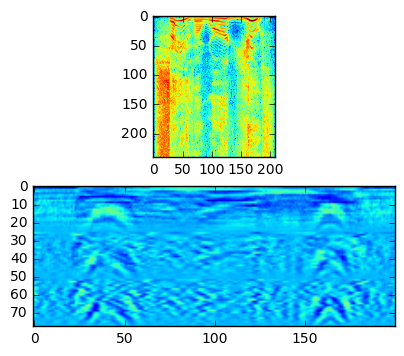

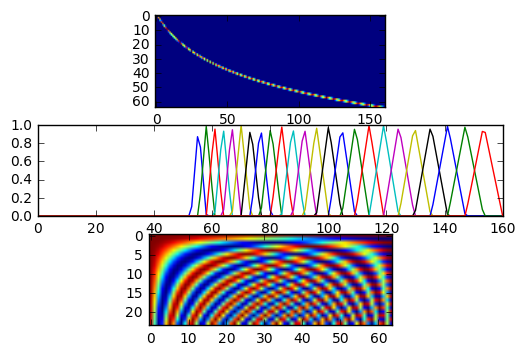

In [34]:
if __name__ == '__main__':
    sr, wav_data = wavfile.read(u"E:\Research Project\OAF_youth_happy.wav")
    mfcc, spect = mfcc_extractor(wav_data, sr, sr//1000*20, sr//1000*10, 52, 26, 'hanning', True)
    pyplot.subplot(211)
    pyplot.imshow(np.log(spect))
    pyplot.subplot(212)
    pyplot.imshow(mfcc)
    pyplot.show()
    pyplot.subplot(311)
    fft2mel = get_fft_mel_mat(320, 16000, 64)
    pyplot.imshow(fft2mel)
    plt.subplot(312)
    plt.hold(True)
    for i in range(24):
        plt.plot(fft2mel[40 + i, :])
    pyplot.subplot(313)
    dct_coeff = get_dct_coeff(64,24)
    pyplot.imshow(dct_coeff)
    pyplot.show()

In [42]:
print("These are the mfcc features for your selected speech -")
print (mfcc)

These are the mfcc features for your selected speech -
[[  7.82602768e+01   8.06759644e+01   8.53633575e+01 ...,   6.29609604e+01
    6.05278740e+01   5.84358902e+01]
 [ -3.06085091e+01  -3.30544395e+01  -3.50181503e+01 ...,  -2.55660057e+01
   -2.73072071e+01  -2.62143402e+01]
 [ -5.02098179e+00  -1.94454169e+00   1.88361549e+00 ...,   1.18328724e+01
    7.71814060e+00   4.52156925e+00]
 ..., 
 [  2.83819222e+00   3.29928780e+00   7.18363702e-01 ...,  -8.95798206e-02
    2.72511691e-01  -2.12406665e-02]
 [  2.62905574e+00   1.47277796e+00  -3.90435249e-01 ...,  -7.45020330e-01
   -5.03552616e-01   2.40015909e-01]
 [  6.92639410e-01  -4.17996138e-01  -8.91945541e-01 ...,   1.07586784e-02
    1.57881939e+00   2.03702784e+00]]


In [15]:
print(spect)

[[  5.61127250e+05   1.11805975e+06   2.48913078e+05 ...,   6.86778438e+04
    2.18139484e+05   9.62984375e+05]
 [  1.80805438e+05   3.31673344e+05   9.24995547e+04 ...,   1.67011445e+04
    5.89505156e+04   2.76348875e+05]
 [  2.94339697e+03   1.60253552e+03   2.45719556e+03 ...,   1.17749643e+01
    1.16843982e+03   9.33672058e+02]
 ..., 
 [  9.57881287e+02   4.05239594e+02   3.14670312e+03 ...,   3.21719086e+02
    4.38789209e+03   2.68718353e+02]
 [  1.72853271e+03   7.77211182e+02   3.79098706e+03 ...,   5.84284241e+02
    9.12600977e+03   9.41828491e+02]
 [  9.12855327e-01   3.27650024e+03   7.58160583e+02 ...,   4.32626562e+03
    1.04583584e+04   2.37436792e+03]]


# SPECTRUM Feature extraction 

In [ ]:
from matplotlib import pyplot
import numpy as np
from scipy.io import wavfile

In [ ]:
def spectrum_extractor(x, win_len, shift_len, win_type, is_log):
    samples = x.shape[0]
    frames = (samples - win_len) // shift_len
    stft = np.zeros((win_len, frames), dtype=np.complex64)
    spectrum = np.zeros((win_len // 2 + 1, frames), dtype=np.float64)

    if win_type == 'hanning':
        window = np.hanning(win_len)
    elif win_type == 'hamming':
        window = np.hamming(win_len)
    elif win_type == 'triangle':
        window = (1 - (np.abs(win_len - 1 - 2 * np.arange(1, win_len + 1, 1)) / (win_len + 1)))
    else:
        window = np.ones(win_len)
    for i in range(frames):
        one_frame = x[i*shift_len: i*shift_len+win_len]
        windowed_frame = np.multiply(one_frame, window)
        stft[:, i] = np.fft.fft(windowed_frame, win_len)
        if is_log:
            spectrum[:, i] = np.log(np.abs(stft[0: win_len//2+1, i]))
        else:
            spectrum[:, i] = np.abs(stft[0: win_len // 2 + 1:, i])

    return spectrum

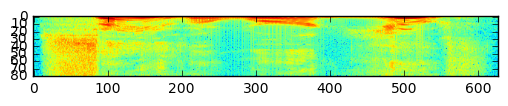

In [36]:
if __name__ == '__main__':
    sr, wav_data = wavfile.read(u"E:\Research Project\OAF_youth_happy.wav")
    spect = spectrum_extractor(wav_data, 160, 80, 'hamming', True)
    pyplot.imshow(spect)
    pyplot.show()

https://librosa.github.io/librosa/tutorial.html

use this website for more information about Librosa library to extract speech feature 